 12.734702 seconds (72.87 M allocations: 4.364 GiB, 8.62% gc time, 5.11% compilation time)


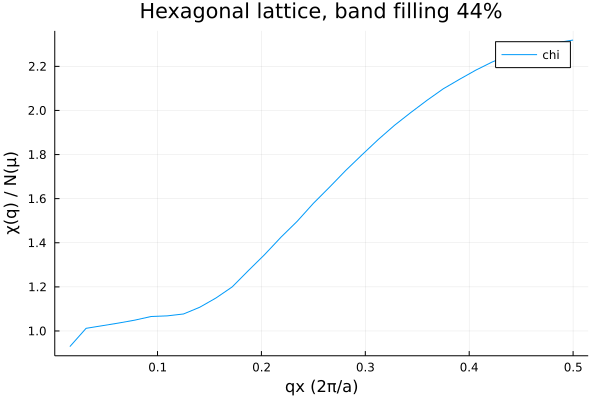

In [6]:
using Printf
using DelimitedFiles
using LinearAlgebra 
using Cubature
using Plots
using FFTW
using QuadGK

const file="graphene_hr.dat"
const ndim = 3
const Emin = -9.0
const Emax= +9
const Ecut = -1.0
const Ndos=200
const dos_smr=0.1
const ωmax = 2
const Nω = 20
const nkx=64
const nky=64
const nkz=1
nk=nkx*nky*nkz
dE = (Emax-Emin)/Ndos


function w0gauss(x,n)::Float64

	if n==-99
		if abs(x)<36
		return 1 / ( 2 + exp(-x) + exp(+x) )
         	else 
		return 0
		end
	else
	arg = min(200,x^2)
	return exp(-arg)/sqrt(pi)
	end
end
	
###########
# Read HamR
###########
function read_hr(hr_file)
nw=0
nr=0
head=0
degen=zeros(0)
open(hr_file) do file
    readline(file)
    nw = parse(Int,readline(file))
    nr = parse(Int,readline(file))
    data = read(file,String)
    sdegen = split(data)[1:nr]
    degen = parse.(Int,sdegen)
end
head = 3 + trunc(Int,nr/15+1)

 ham_data = zeros(nr*nw*nw,7)
 open(hr_file) do file
 ham_data = readdlm(file, Float64, skipstart=head)
 end

 HamR = reshape(ham_data[:,6],nw,nw,nr) + reshape(ham_data[:,7],nw,nw,nr)*1im

  Rx = reshape(ham_data[:,1],nw,nw,nr)[1,1,1:nr]
  Ry = reshape(ham_data[:,2],nw,nw,nr)[1,1,1:nr]
  Rz = reshape(ham_data[:,3],nw,nw,nr)[1,1,1:nr]
  R = hcat(Rx, Ry, Rz)

return (HamR, degen, R)
end
 

function HamK(K)
    HamK = zeros(nw,nw)*1im
    nr = size(HamR,3)
    for ir = 1:nr
        rdotk = dot( K[:], R[ir,:] )
        fac = exp( 2pi*rdotk*1im )
        HamK += fac * HamR[:,:,ir] / degen[ir]
    end
    return Hermitian(HamK)
end

function G(K,E)
    η = dos_smr
    G = inv( (E + im*η)*I - HamK(K) )
    return G
end

function specfun(E)
  A = 0.0
    for ikx = 1:nkx , iky = 1:nky, ikz=1:nkz
        K = [ (ikx-1)/nkx, (iky-1)/nky, (ikz-1)/nkz ]
        A += imag(tr(G(K,E))) / nk
    end
 #A = pcubature( K -> imag(tr(G(E,[K;0.0]))), [-0.5,-0.5], [0.5,0.5], reltol=0, abstol=1e-5, maxevals=5000)
    return -A[1]/π
end


function Gr(E) #mesh
Gk = zeros(nkx,nky,nkz,nw,nw)*im
Gr = zeros(nkx,nky,nkz,nw,nw)*im
GrT = zeros(nkx,nky,nkz,nw,nw)*im
for ikx = 1:nkx , iky = 1:nky, ikz=1:nkz
K = [ (ikx-1)/nkx, (iky-1)/nky, (ikz-1)/nkz ]
Gk[ikx,iky,ikz,:,:] = G(K,E)
end
for m = 1:nw, n = 1:nw
Gr[:,:,:,m,n] =  bfft(Gk[:,:,:,m,n],1:ndim)
end
return Gr/nk      
end


function χR()
#f(E) = Gr(E).*Gr(E)
chiR = 1im*zeros(nkx,nky,nkz,nw,nw)
for E = Emin : dE : Ecut
    G12 = Gr(E)
#    G21 = permutedims(G12,[1,2,3,5,4])
    chiR += G12 .* G12 *dE
end
# result = quadgk(f, Emin, Ecut, rtol = 0, atol = 1e-3, maxevals = 200, order=2)
# chiR = result[1]
 return chiR / π
end

function χK()
chiK = 1im*zeros(nkx,nky,nkz,nw,nw)
chiK[:,:,:,:,:] = fft( χR()[:,:,:,:,:], 1:ndim)
return chiK
end
    

###########
# Calc DOS
###########
function dos(E)
dos = 0.0
wk = 1/nk
for ikx = 1:nkx , iky = 1:nky, ikz=1:nkz
    ik = ikz + nkz*(iky-1) + nkz*nky*(ikx-1)
    for iw = 1:nw
	arg = (E - Ek[iw,ik])/dos_smr
	dos += w0gauss(arg,-99)/dos_smr * wk
    end
end
return dos
end

###########
# Main part
###########

@time begin

(HamR, degen, R) = read_hr(file)
nw = size(HamR,1)
Ek = zeros(nw,nk)
    
for ikx = 1:nkx , iky = 1:nky, ikz=1:nkz
    ik = ikz + nkz*(iky-1) + nkz*nky*(ikx-1)
    K = [ (ikx-1)/nkx, (iky-1)/nky, (ikz-1)/nkz ]
    Ek[:,ik] = eigvals(HamK(K))
end
#Emin = minimum(Ek)
#Emax = maximum(Ek)

chiK = 1im*zeros(nkx,nky,nkz,nw,nw)
chiK = χK()
chisum = sum(chiK, dims=4:5)
    
Erange = Emin : dE : Emax
dos_at_ef = dos(Ecut)
qrange = (1:round(Int,nkx/2)) /nkx
    
#P = plot(Erange, dos, label="DOS", title="Output", xlabel="Energy (eV)", ylabel=("DOS (states/eV)"))
P2 = plot(qrange, x -> imag(chisum[round(Int,x*nkx),1,1])/dos_at_ef, title="Hexagonal lattice, band filling 44%", label="chi", xlabel="qx (2π/a)", ylabel=("χ(q) / N(μ)"))
    
outfile = "dos.dat"
f = open(outfile, "w")    
for E=Emin:dE:Emax
    @printf(f,"%12.12f %12.12f \n", E, dos(E))
end
close(f)

outfile = "chiK.dat"
f = open(outfile, "w")    
for qx in qrange
    iqx = round(Int,qx*nkx)
    @printf(f,"%12.12f %12.12f %12.12f \n", qx, real(chisum[iqx,1,1])/dos_at_ef, imag(chisum[iqx,1,1])/dos_at_ef )
end
close(f)
    
plot(P2)
    
end



In [29]:
savefig("graphene.png")